In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

# Exploratory Data Analysis (EDA)

### 1. Load train set and sample the dataset to a manageable size if necessary

In [2]:
data = pd.read_csv('data/data_train.csv')
data.head()

,Address,Zip,Price,Area,Room,Lon,Lat
0,"Marcantilaan 123, Amsterdam",1051 LW,325000.0,41,2,4.867459,52.375562
1,"Vossiusstraat 71, Amsterdam",1071 AK,2500000.0,202,6,4.876117,52.359763
2,"Prinsengracht 1035 D, Amsterdam",1017 KP,825000.0,148,3,4.895224,52.361929
3,"Doornburg 155, Amsterdam",1081 JX,699000.0,98,3,4.861985,52.322384
4,"Weesperzijde 114 huis, Amsterdam",1091 EN,1795000.0,158,6,4.912109,52.350755


### 2. For supervised learning tasks, identify the target attribute

In [3]:
TARGET = 'Price'

### 3. Study each attribute and its characteristics:

1. **Name**

In [4]:
data.columns

Index(['Address', 'Zip', 'Price', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')

2. **Type (categorical, int/float, bounded/unbounded, text, structured, etc.);**

In [5]:
df_datatype = pd.DataFrame.from_dict(
    {
        "Price": "continuous",  # <- This is our TARGET
        "Address": "text",      # assumption: might be non-informative, because there is also longtitude and latitude data present, which might appear to be more infirmative
        "Zip": "text",          # because zip contains not only numbers, but also letters
        "Area": "continuous",
        "Room": "descrete",
        "Lon": "continuous",
        "Lat": "continuous",
    },
    orient="index",
    columns=["data_type"],
)
display(df_datatype.transpose())

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous


3. **Percentage of missing values;**

In [6]:
print(
    f"o {data.isna().sum().sum()} ({data.isna().sum().sum()*100/data.shape[0]*data.shape[1]:.2f}%) missing values"
)

o 3 (2.84%) missing values


Check if missing values are represented in a different way as in the description of the dataset it is stated that there are missing values.

In [7]:
# Uncomment to inspect all columns

# for column in data.columns:
#     print(f"{column}: {data[column].unique()}")

There is no missing data, that is represented in a different way.

In [8]:
df_missing_value = data.isna().sum().to_frame(name="missing values")
display(df_missing_value.transpose())

,Address,Zip,Price,Area,Room,Lon,Lat
missing values,0,0,3,0,0,0,0


In [9]:
data[data.isna().any(axis=1)]

,Address,Zip,Price,Area,Room,Lon,Lat
84,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
173,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707
180,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


4. **Check if there are duplicates**

In [10]:
print(
    f"o {data.duplicated().sum()} ({data.duplicated().sum()/len(data):.3f}%) duplicate values"
)

o 1 (0.001%) duplicate values


5. **Check outliers**

1. Let's check the **distribution** of the **numerical** (continuous and descrete) independent variables

In [11]:
list_numerical = []
for col in data.columns:
    if df_datatype['data_type'][col] == "continuous" or df_datatype['data_type'][col] == "descrete":
        list_numerical.append(col)

list_numerical

['Price', 'Area', 'Room', 'Lon', 'Lat']

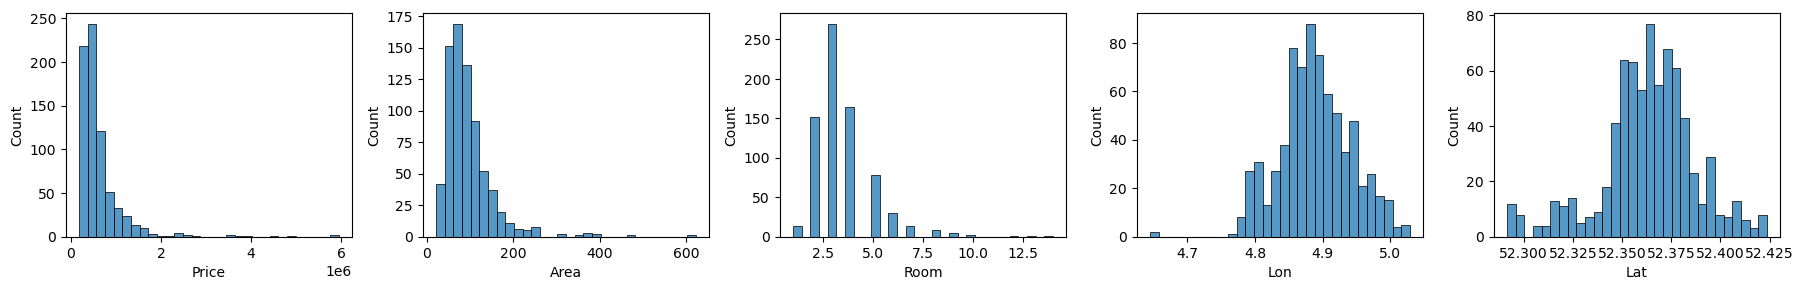

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for i, col in enumerate(list_numerical):
    plot = sns.histplot(ax=axes.flatten()[i], x = data[col], bins = 30)

plt.tight_layout() 

**a.** Price, Area and Room are right scewed destributions, that is why simple ± 3std rule can not be applied to detect outliers. Instead, we can apply Q3 +1.5(IQR) rule:

In [13]:
for i in ['Price', 'Area', 'Room']:
    Q3 = np.nanpercentile(data[i], [75])[0]
    IQR = stats.iqr(data[i], interpolation = 'midpoint', nan_policy='omit')

    outlier_border = Q3 + 1.5*IQR

    outliers = data[data[i]>outlier_border]
    print(f'o {outliers.shape[0]} datapoints with {i} > {outlier_border}')

    #uncomment to see lists of all outliers
    # display(outliers)

o 56 datapoints with Price > 1225000.0
o 33 datapoints with Area > 189.75
o 62 datapoints with Room > 5.5


There is one data point, that seems to be a data mistake: row 382 (with index 381): there is only 1 room per 258 sq.m. 
All other outliers are just big expensive houses.

**b.** Longtitude and Latitude look like normal distribution, so ± 3std rule for identifying outliers can be applied:

In [14]:
location_outliers = pd.DataFrame()

for i in ['Lon', 'Lat']:

    #get all nessesary data
    mean = data[i].mean()
    std = data[i].std()
    lower_treshold = mean - 3 * std
    upper_threshold = mean + 3 * std
    values_below_3std = data.loc[data[i] < lower_treshold, i].values
    values_above_3std = data.loc[data[i] > upper_threshold, i].values
    

    # add data to dataframe
    location_outliers = pd.concat(
        [
            location_outliers,
            pd.DataFrame(
                data={
                    "Mean": round(mean, 5),
                    "Standard deviation": std,
                    "Lower threshold": round(lower_treshold, 5),
                    "N of lower outliers": len(values_below_3std),
                    "Lower outliers": [values_below_3std],
                    "Upper threshold": round(upper_threshold, 5),
                    "N of upper outliers": len(values_above_3std),
                    "Upper outliers": [values_above_3std],
                },
                index=[i],
            ),
        ]
    )

location_outliers

,Mean,Standard deviation,Lower threshold,N of lower outliers,Lower outliers,Upper threshold,N of upper outliers,Upper outliers
Lon,4.88894,0.053376,4.72881,2,"[4.655161, 4.644819]",5.04907,0,[]
Lat,52.36324,0.023811,52.29180,2,"[52.291672, 52.291519]",52.43467,0,[]


As we can see, there are 2 outliers below 3std both for Longtitude and for Latitude. Lel's plot Lat vs Lon and see what the map of houses looks like:

<Axes: xlabel='Lat', ylabel='Lon'>

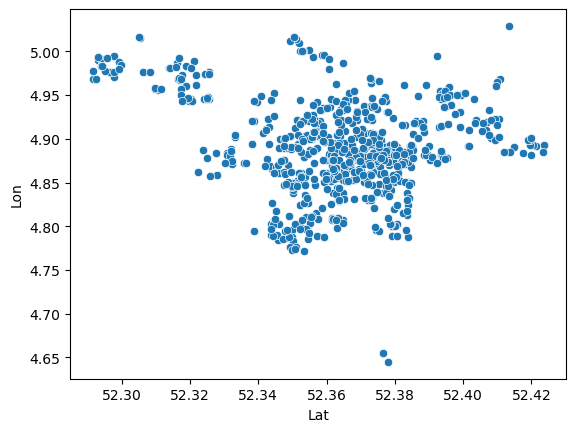

In [15]:
sns.scatterplot(x=data['Lat'], y=data['Lon'])

Two points at the bottom of plot are longitude outliers. However those 2 of latitude seem to belong to the small cluster on the left side of the plot, which might be a small residential area a bit outside of the main area. 

There is one more point, that was not included nither to longitude nor to latitude outliers, looks like another outlier though: the on in the top right corner. Longitude might be close to upper longitude 3std border, latitude fits inside 3std. Lets check this point:

In [16]:
data.loc[lambda x: x["Lon"] > 5, ("Lat", 'Lon')]

,Lat,Lon
6,52.351935,5.009082
162,52.350961,5.014044
219,52.350513,5.016555
262,52.350556,5.016505
309,52.349139,5.012134
324,52.354845,5.001384
349,52.305296,5.015376
364,52.352820,5.000330
388,52.353136,5.000973
427,52.413550,5.029122


In [17]:
# how far is the point from the mean latitude (based on formula x = mean + n*std)

n = (52.413550 - 52.36324) / 0.023811
n

2.1128890008820793

The value 2 means that this point is in 5% minority of data, that lies behind ±2std. Can easily be classified as outlier counting the fact, that also latitude is the highest for this longitude sector (>5).

2. Check text data (Address and ZIP)

In [18]:
data['Address'].value_counts()

Address
Huidekoperstraat 24 F, Amsterdam        2
Quashibastraat, Amsterdam               2
Nieuwevaartweg, Amsterdam               2
Ringdijk, Amsterdam                     2
Van Boetzelaerstraat 36 1, Amsterdam    1
                                       ..
Fahrenheitsingel 17, Amsterdam          1
De Wittenkade 23 2V, Amsterdam          1
Utrechtsedwarsstraat 4, Amsterdam       1
Kloekhorststraat 231, Amsterdam         1
Zandstraat 5 hs, Amsterdam              1
Name: count, Length: 735, dtype: int64

There are 735 unique addresses out of 739 datapoints. That will not give a lot of information in terms of prediction. Let's check zip codes:

In [19]:
data['Zip'].value_counts()

Zip
1075 XR    4
1011 AW    3
1060 RZ    3
1087 VS    3
1068 WT    3
          ..
1013 CA    1
1097 NR    1
1052 AA    1
1017 WG    1
1011 HJ    1
Name: count, Length: 673, dtype: int64

It looks slightly better: there are some houses with the same zip codes and there could be dependancy between zip and price of the house. However, if we investigate the princip of zip codes formation, it is easy to discover, that main regions of the city are marked with 4 numbers, and subregions, which usually include just a couple of houses, are marked with 2 letters. When first digits are 1 and 0, it means the house is in Amsterdam. Even though the dataset is about this city, there are also zip codes, which start with 11 - that is a Zuidost area, which is a bit futher from the city. The assumption is that there might be less clusters (and thus more predictable), if use only 4 digits instead of 4 digits + 2 letters. Let's try to separate them:

In [20]:
data['Zip num'] = np.nan
data['Zip letters'] = np.nan
for row in range(data.shape[0]):
    data['Zip num'][row] = data['Zip'][row][:-3]
    data['Zip letters'][row] = data['Zip'][row][5:]

/var/folders/32/8k8cb3jn77bbc7_7_m5_xlf00000gn/T/ipykernel_4218/3335978991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Zip num'][row] = data['Zip'][row][:-3]
/var/folders/32/8k8cb3jn77bbc7_7_m5_xlf00000gn/T/ipykernel_4218/3335978991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Zip letters'][row] = data['Zip'][row][5:]


In [21]:
data['Zip num'].value_counts()

Zip num
1058    24
1017    23
1024    20
1013    20
1053    20
        ..
1023     2
1108     2
1109     2
1028     2
1022     1
Name: count, Length: 70, dtype: int64

The assumption is accepted: there are 9 times less clusters when using only numbers of zip code. This hypothesis will be tested when different models will be applied.

### 4. Study the correlations between attributes

In [22]:
numerical_data = data[['Price', 'Area', 'Room', 'Lat', 'Lon', 'Zip num']]

<Axes: >

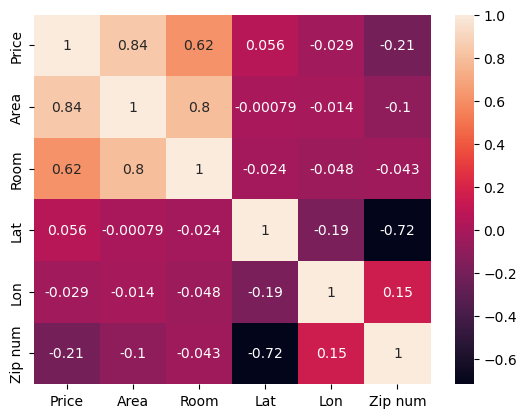

In [23]:
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot = True)

There is **high** correlation between:
 - Price and Area (positive)
 - Area and Room (positive)
 - Latitude and Zip (negative)

There is **moderate** correlation between:
 - Price and Room (positive)

There is **low** correlation between:
- Price and Zip (negative)
- Longitude and Latitude (positive)
- Longitude and Zip (negative)

### 5. Identify the promising transformations that may be applied.

1. Divide Zip to numbers and letters.
2. Add price per square meter, as in the world of real estate that is more important than a price of a house.
3. Having coordinates of latitude and longitude, it is posible to define a 'center' point as a city center, where the houses are usually more expencive, and calculate distance to every datapoint as a vector.
4. Address data in original format is not informative and needs to be changed.

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

